In [0]:
#@title Install prerequsite

!pip install lifelines
!pip install shap

     |████████████████████████████████| 389kB 2.7MB/s 
     |████████████████████████████████| 266kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.33.0-cp36-cp36m-linux_x86_64.whl size=382263 sha256=9073581630c468783bf3c8a418debcdf45c973b2ebf29c4db3edc4a910a2de65
  Stored in directory: /root/.cache/pip/wheels/39/0f/88/a8124d43431284e10f263ffe449e119344c6145c3a165d186c
Successfully built shap


In [0]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from pathlib import Path

# Change this to where you download the files
DATA = Path("/content/drive/My Drive/Genomic Info/mini-challenge/data")

In [0]:
import pandas as pd

pfs_train = pd.read_csv(DATA / "pfs_train.txt", sep="\t", index_col="patient_id")
pfs_train.head()

,progression,time_to_progression_or_censor
patient_id,,
TRAIN_0000,1.0,334.0
TRAIN_0001,0.0,1523.0
TRAIN_0002,0.0,121.0
TRAIN_0003,1.0,334.0
TRAIN_0004,1.0,183.0


As part of EDA, we can first construct the overall survival curve using the `lifelines` package.

### Clinical data

Regarding the features we will be using to predict survival, take a look at the clinical table:

In [0]:
clin_train = pd.read_csv(DATA / "clinical_train.txt", sep="\t", index_col="patient_id")

# also load clin_test
clin_test = pd.read_csv(DATA / "clinical_test.txt", sep="\t", index_col="patient_id")

clin_train.head()

,age_at_initial_pathologic_diagnosis,anatomic_neoplasm_subdivision,diagnosis,eastern_cancer_oncology_group,ethnicity,gender,karnofsky_performance_score,laterality,location_in_lung_parenchyma,number_pack_years_smoked,pathologic_M,pathologic_N,pathologic_T,pathologic_stage,race,radiation_therapy,residual_tumor,tobacco_smoking_history
patient_id,,,,,,,,,,,,,,,,,,
TRAIN_0000,81,L-Upper,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],32,M0,N2,T2,Stage IIIA,[Not Available],[Not Available],R2,4
TRAIN_0001,67,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],Peripheral Lung,52,M0,N0,T2,Stage IB,[Not Available],[Not Available],R0,3
TRAIN_0002,79,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],FEMALE,[Not Available],[Not Available],[Not Available],47,M0,N1,T3,Stage IIIA,[Not Available],[Not Available],R2,4
TRAIN_0003,68,L-Upper,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],62,M0,N0,T2,Stage IB,[Not Available],[Not Available],R0,4
TRAIN_0004,66,R-Lower,Lung Adenocarcinoma,[Not Available],[Not Available],MALE,[Not Available],[Not Available],[Not Available],20,M0,N2,T2,Stage IIIA,[Not Available],[Not Available],RX,3


In [0]:
def cat_cont_summary_for_col(col: pd.Series, cat_cutoff: int):
    """Given a :class:`pandas.Series`, calculate its cardinality, and if its
    continuous, show summary statistics; if categorical, show unique values
    
    Arguments
    ---------
    col: pandas.Series
        Input series
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_info: dict
        A dictionary containing info regarding the input series. If the series
    """
    card = col.nunique()
    col_type = "cat" if card <= cat_cutoff else "cont"
    if col_type == "cont":
        col = pd.to_numeric(col, errors="coerce")
    else:
        col = col.astype(str)

    col_info = {
        "cardinality": card,
        "col_type": col_type,
        **col.describe()
    }
    if col_type == "cat":
        col_info["unique_values"] = col.unique()

    return col_info


def cat_cont_summary_for_df(df: pd.DataFrame, cat_cutoff: int = 20):
    """Given a :class:`pandas.DataFrame`, determine whether each column is
    categorical or continuous, and output its summary statistics
    
    Arguments
    ---------
    df: pandas.DataFrame
        Input data frame
    cat_cutoff: int
        Cutoff cardinality to determine whether a series is categorical or
        continuous

    Returns
    -------
    col_summary: pandas.DataFrame
        A :class:`pandas.DataFrame` summarizing the statistics of each column
    """
    col_sums = [cat_cont_summary_for_col(df[col], cat_cutoff)
                for col in df.columns]
    col_summary = pd.DataFrame(col_sums)
    col_summary.index = df.columns.values
    return col_summary

In [0]:
import numpy as np

def replace_by_na(col: pd.Series, char: str = "["):
    idx = [char in str(x) for x in col]
    _col = col.copy()
    _col.loc[idx] = np.NaN
    return _col

# perform the same transformation to both clin_train and clin_test
for col in clin_train.columns:
    clin_train[col] = replace_by_na(clin_train[col])
    clin_test[col] = replace_by_na(clin_test[col])


After this process, we can see the values in brackets are all converted to `np.NaN`

In [0]:
cat_cont_summary_for_df(clin_train)

,cardinality,col_type,count,mean,std,min,25%,50%,75%,max,unique,top,freq,unique_values
age_at_initial_pathologic_diagnosis,52,cont,801.0,66.224719,9.476652,33.00,60.0,67.00,73.0,88.0,NaN,NaN,NaN,NaN
anatomic_neoplasm_subdivision,7,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,R-Upper,251.0,"[L-Upper, R-Lower, R-Upper, L-Lower, R-Middle,..."
diagnosis,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,Lung Adenocarcinoma,413.0,"[Lung Adenocarcinoma, Lung Squamous Cell Carci..."
eastern_cancer_oncology_group,4,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,nan,488.0,"[nan, 1, 0, 3, 2]"
ethnicity,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NOT HISPANIC OR LATINO,575.0,"[nan, NOT HISPANIC OR LATINO, HISPANIC OR LATINO]"
gender,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,MALE,492.0,"[MALE, FEMALE]"
karnofsky_performance_score,9,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,nan,664.0,"[nan, 0, 80, 90, 50, 100, 70, 40, 60, 20]"
laterality,0,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,nan,816.0,[nan]
location_in_lung_parenchyma,2,cat,816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,nan,469.0,"[nan, Peripheral Lung, Central Lung]"
number_pack_years_smoked,127,cont,622.0,47.547516,28.168011,0.15,28.0,40.25,60.0,180.0,NaN,NaN,NaN,NaN


The following code selected a few columns of interests (arbitrarily), convert the categorical variables to [one-hot encoding](https://medium.com/@michaeldelsole/what-is-one-hot-encoding-and-how-to-do-it-f0ae272f1179), then these data frames are machine-learning ready.

In [0]:
cat_cols = ["diagnosis", "pathologic_M", "pathologic_N", "pathologic_T",
            "radiation_therapy", "residual_tumor"]
cont_cols = ["age_at_initial_pathologic_diagnosis", "tobacco_smoking_history",
             "karnofsky_performance_score"]

In [0]:
# Concatenate categorical variables of interest and numerical variables of
# interest into ml-ready matrices
x_clin_train = pd.concat([pd.get_dummies(clin_train[cat_cols]),
                          clin_train[cont_cols]], axis=1, sort=True)

x_clin_test = pd.concat([pd.get_dummies(clin_test[cat_cols]),
                         clin_test[cont_cols]], axis=1, sort=True)

### RNASeq data

RNASeq data is very straight-forward. We have ~37,000 gene's expression values, all of them are log2 transformed, continuous values. 

In [0]:
ge_train = pd.read_csv(DATA / "rnaseq_train.txt", sep="\t", index_col=0)
ge_test = pd.read_csv(DATA / "rnaseq_test.txt", sep="\t", index_col=0)

ge_train.head()

,TRAIN_0001,TRAIN_0002,TRAIN_0003,TRAIN_0004,TRAIN_0005,TRAIN_0006,TRAIN_0007,TRAIN_0008,TRAIN_0009,TRAIN_0010,TRAIN_0011,TRAIN_0012,TRAIN_0013,TRAIN_0014,TRAIN_0015,TRAIN_0016,TRAIN_0017,TRAIN_0018,TRAIN_0019,TRAIN_0020,TRAIN_0021,TRAIN_0022,TRAIN_0023,TRAIN_0024,TRAIN_0025,TRAIN_0026,TRAIN_0027,TRAIN_0028,TRAIN_0029,TRAIN_0030,TRAIN_0031,TRAIN_0032,TRAIN_0033,TRAIN_0034,TRAIN_0035,TRAIN_0036,TRAIN_0037,TRAIN_0038,TRAIN_0039,TRAIN_0040,...,TRAIN_0776,TRAIN_0777,TRAIN_0778,TRAIN_0779,TRAIN_0780,TRAIN_0781,TRAIN_0782,TRAIN_0783,TRAIN_0784,TRAIN_0785,TRAIN_0786,TRAIN_0787,TRAIN_0788,TRAIN_0789,TRAIN_0790,TRAIN_0791,TRAIN_0792,TRAIN_0793,TRAIN_0794,TRAIN_0795,TRAIN_0796,TRAIN_0797,TRAIN_0798,TRAIN_0799,TRAIN_0800,TRAIN_0801,TRAIN_0802,TRAIN_0803,TRAIN_0804,TRAIN_0805,TRAIN_0806,TRAIN_0807,TRAIN_0808,TRAIN_0809,TRAIN_0810,TRAIN_0811,TRAIN_0812,TRAIN_0813,TRAIN_0814,TRAIN_0815
A1BG,-1.3364,-1.7668,-1.0198,-0.8983,-5.9363,0.3527,-3.0055,-2.3069,-2.1904,-1.2656,-1.3568,-0.7001,-2.8087,-1.0790,-1.5845,-1.2057,-1.6855,-1.1610,0.4233,-3.0186,-1.7536,-1.3744,-0.7374,-4.0285,-3.9233,-3.0484,-1.3048,-2.3104,-3.3131,-4.6724,-2.4712,-2.6891,-4.0212,-3.2784,-1.4477,-3.3057,-1.9225,-3.4339,-2.0238,-1.0988,...,-1.5283,-1.3231,-0.9713,-0.9121,-0.9251,-1.0919,0.2249,-0.6211,-3.3718,-2.0011,-0.9321,-1.0119,-1.3776,-1.4497,-2.0486,-3.0911,0.6557,0.4914,-0.1059,1.1786,-1.9261,-0.4090,-0.3578,-1.9184,0.4643,0.5011,-3.6151,-2.0062,-1.6154,-1.8095,-0.3868,0.4650,0.6863,-1.3412,-0.3093,-0.5301,-1.9589,-3.5359,-1.4197,-1.5915
A1BG-AS1,1.7801,0.7311,1.3790,1.4652,-1.1814,2.4569,-0.3547,0.1567,-0.4160,0.1432,1.0081,1.3865,0.2076,0.8685,-0.4850,1.6472,1.0725,2.1088,1.9816,-0.6165,-0.1687,1.0956,2.0803,-0.5321,-0.7533,0.3515,0.6253,1.5405,0.9846,-1.1280,0.6834,0.9465,-1.7841,0.5763,1.3927,-1.0927,0.3995,-1.5358,0.9184,2.0496,...,1.1689,0.9989,1.5540,1.3656,1.4299,0.8419,2.1225,1.1096,-0.4218,1.5061,1.0749,1.8351,0.4968,1.0799,0.6248,-0.1076,2.4359,2.0764,2.0007,3.6502,0.1443,2.3077,1.1210,0.4837,2.2172,2.0787,0.0854,0.3697,0.9461,0.9194,1.0042,2.7258,3.2015,1.5483,2.0472,1.6936,-0.0731,-1.6099,0.9022,0.3975
A1CF,-4.3104,-6.9762,-6.0047,-2.7964,1.4124,-6.1761,-7.6493,-1.7065,-4.1164,-6.1236,-5.4997,-5.0364,-6.2681,-2.1363,0.8936,-3.2891,4.6606,-3.7933,-3.4446,3.3810,-5.8411,-4.2620,-4.7193,-6.8359,-5.5082,-6.2184,-4.9292,-5.1178,-6.4830,-6.2573,-6.8635,-5.4965,-3.6586,-5.6003,-6.6572,-5.1801,-6.9669,-6.8933,-5.5681,-6.5907,...,-3.8503,-6.5325,-4.5958,-6.6400,-5.4486,-6.3773,-3.6819,-2.6421,-5.2462,-6.7560,-3.7972,-6.3695,-5.7699,-4.0819,-5.3216,-6.5505,-5.4528,-6.1668,-2.2473,-1.6288,-3.4595,-4.7548,-4.3275,-3.9888,2.9479,-4.2104,-5.9370,-4.8136,-4.9846,-6.5644,-6.1147,-2.3639,-4.3047,-6.6266,-1.3841,-2.4416,-4.8975,-3.7423,-2.3708,-5.0510
A2M,10.2830,9.7800,10.0746,11.1037,10.1339,9.2526,9.9767,10.8297,7.7219,10.6659,8.2200,9.3291,8.6852,9.4124,10.7804,10.0078,9.1490,9.0152,7.9316,8.7049,10.1049,10.1162,7.5333,7.9038,7.5614,7.7608,7.6639,8.8712,7.0693,7.6023,8.2200,8.7249,7.1395,8.7063,8.2883,7.4633,7.1652,7.1328,10.0292,8.1975,...,10.7359,10.1068,9.7267,9.8094,9.0229,6.3728,7.9693,7.1119,6.3637,10.8858,7.7719,6.7333,6.4983,7.5106,7.8337,6.9946,7.7285,8.4274,9.0582,9.8243,9.1790,9.2028,11.1617,10.0291,10.1678,7.7649,6.6188,6.4436,8.4880,7.7960,5.2123,10.2018,8.2129,8.3069,7.2597,7.9215,7.8997,9.5837,11.1142,9.2260
A2M-AS1,-0.4035,-0.7095,1.2080,-0.2786,-0.3216,-0.6842,-0.4894,-0.6612,1.3232,0.0663,-0.2903,0.2490,0.1413,0.0721,-1.3330,-0.5834,0.8852,0.1136,0.1161,-0.4684,-1.3175,1.4217,-0.1464,0.4215,0.6279,0.7474,-0.0713,1.8011,-0.0736,0.1177,0.8712,1.4693,0.5024,-0.9954,-0.9292,0.6012,0.8973,0.2462,0.3467,-1.2331,...,-0.0878,0.2619,0.5058,0.4580,0.1856,1.3709,0.4428,1.3093,-0.9486,0.8513,1.2220,0.4507,0.7999,0.6074,0.4772,0.6879,-0.3513,-0.1444,-0.9085,-1.1982,-0.3238,0.0353,0.0649,0.1971,0.4249,-1.4879,-0.2091,-1.1131,0.2249,1.2494,0.7054,-0.3080,-0.9542,-1.6724,0.6538,-0.1474,0.6365,0.3054,-0.3004,-0.6586


In [0]:
cidx_df = pd.read_csv("/content/drive/My Drive/Genomic Info/Genomics Project/cidx.txt",
                      sep=",")
cidx_df.head()

,Unnamed: 0,gene,cidx,dev_from_random
0,29893,SESN3,0.614928,0.114928
1,32863,TESK2,0.606131,0.106131
2,19872,NTRK2,0.604501,0.104501
3,8276,FMO4,0.601611,0.101611
4,8167,FGFR2,0.601530,0.101530


In [0]:
#Ran and saved cidx to drive
# mat = pd.concat([pfs_train, ge_train.transpose()], axis=1, sort=True).dropna()

In [0]:
# from tqdm import tqdm
# from lifelines.utils import concordance_index

# out = []

# # calculate concordance index for all genes, THIS WILL TAKE A WHILE
# for i in tqdm(range(2, mat.shape[1]), total=mat.shape[1] - 2):
#     out.append((mat.columns[i],
#                 concordance_index(mat.time_to_progression_or_censor,
#                                   mat.iloc[:, i],
#                                   mat.progression)))

In [0]:
# cidx_df = pd.DataFrame(out)
# cidx_df.columns = ["gene", "cidx"]
# cidx_df["dev_from_random"] = (cidx_df.cidx - 0.5).abs()
# cidx_df.sort_values("cidx", ascending=False, inplace=True)
# cidx_df

In [0]:
# cidx_df
# cidx_df['cidx'] =  pd.to_numeric(cidx_df['cidx'],errors='coerce')
# cidx_df['dev_from_normal'] =  pd.to_numeric(cidx_df['dev_from_normal'],errors='coerce')
# cidx_df = cidx_df.sort_values('cidx').dropna().drop_duplicates()
# cidx_df.drop_duplicates()
# cidx_df.to_csv('/content/drive/My Drive/Genomic Info/cidx.txt')

In [0]:
# create gene sets out of top concordance index genes
top_genes_negative = cidx_df.iloc[:400].gene
top_genes_positive = cidx_df.iloc[-400:].gene
_ge = ge_train.loc[pd.concat([top_genes_negative,
                              top_genes_positive], axis=0)].copy()

In [0]:
corr = (_ge.T).corr()

In [0]:
import scipy.spatial as sp
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import squareform

cor_dist = 1 - (corr + 1) / 2
linkage = hc.linkage(squareform(cor_dist), method="average")
labels = cor_dist.columns.values
coexp_set = pd.DataFrame({"cluster": hc.fcluster(linkage, 0.25,"distance"),
                          "gene": labels})

In [0]:
def create_coexp_ge_features(ge, coexp_set, min_gene_set=10):
    geneset_size = coexp_set.groupby("cluster").size()
    geneset_size = geneset_size[geneset_size >= min_gene_set]

    coexp_set_ = coexp_set.set_index("cluster", drop=True)

    tmp = {}
    for gs in geneset_size.index.values:
        genes = coexp_set_.loc[gs].gene.values
        if geneset_size[gs] <= 5:
            gsname = "_".join(list(genes))
        else:
            gsname = genes[0] + "_" + "geneset"
        
        tmp[gsname] = ge.loc[genes].mean(axis=0)
    
    return pd.DataFrame(tmp)
create_coexp_ge_features(ge_train, coexp_set)

,PRRC1_geneset,CRACR2B_geneset,SESN3_geneset
TRAIN_0001,6.75033,5.249480,-1.240689
TRAIN_0002,6.35708,5.302093,-0.940106
TRAIN_0003,6.39670,5.036047,-0.627491
TRAIN_0004,6.14906,5.933267,-0.863134
TRAIN_0005,6.97348,5.828440,-1.302599
...,...,...,...
TRAIN_0811,5.00137,2.094553,4.100761
TRAIN_0812,3.98011,2.652453,4.088698
TRAIN_0813,5.01441,3.191147,0.233559
TRAIN_0814,5.81540,5.221880,-0.436857


In [0]:
ge_train_feat = create_coexp_ge_features(ge_train, coexp_set)
ge_test_feat = create_coexp_ge_features(ge_test, coexp_set)
ge_train_feat

,PRRC1_geneset,CRACR2B_geneset,SESN3_geneset
TRAIN_0001,6.75033,5.249480,-1.240689
TRAIN_0002,6.35708,5.302093,-0.940106
TRAIN_0003,6.39670,5.036047,-0.627491
TRAIN_0004,6.14906,5.933267,-0.863134
TRAIN_0005,6.97348,5.828440,-1.302599
...,...,...,...
TRAIN_0811,5.00137,2.094553,4.100761
TRAIN_0812,3.98011,2.652453,4.088698
TRAIN_0813,5.01441,3.191147,0.233559
TRAIN_0814,5.81540,5.221880,-0.436857


In [0]:
# gene sets from https://academiccommons.columbia.edu/doi/10.7916/D8NP22JK 
attractors = {
    "LYM": ["SASH3", "CD53", "NCKAP1L", "LCP2", "IL10RA", "PTPRC", "EVI2B",
            "BIN2", "WAS", "HAVCR2"],
    "CIN": ["TPX2", "KIF4A", "KIFC1", "NCAPG", "BUB1", "NCAPH", "CDCA5",
            "KIF2C", "PLK1", "CENPA"],
    "MES": ["COL3A1", "COL5A2", "COL1A2", "THBS2", "COL5A1", "VCAN", "COL6A3",
            "SPARC", "AEBP1", "FBN1"],
    "END": ["CDH5", "ROBO4", "CXorf36", "CD34", "CLEC14A", "ARHGEF15", "CD93",
            "LDB2", "ELTD1", "MYCT1"]
}

def create_metagenes(ge, genesets):
    tmp = {}
    for gs in genesets:
        genes = [x for x in genesets[gs] if x in ge.index]
        tmp[gs] = ge.loc[genes].mean(axis=0)
    return pd.DataFrame(tmp)

In [0]:
ge_train_feat = pd.concat(
    [ge_train_feat, create_metagenes(ge_train, attractors)], axis=1
)

ge_test_feat = pd.concat(
    [ge_test_feat, create_metagenes(ge_test, attractors)], axis=1
)

We'll just use these top genes to feed to our models. If you want to further improve, you can also try to **combine co-expressed genes into gene set** to reduce co-linearity.

In [0]:
x_ge_train = ge_train_feat.copy()
x_ge_test = ge_test_feat.copy()

### Mutation data

Finally let's take a look at mutation data. The mutation data has the same format of MAF files. Here we'll aggregate the `MODERATE` and `HIGH` impact mutations by genes and pivot it into a matrix.

In [0]:
mut_train = pd.read_csv(DATA / "mut_train.txt", sep="\t")
mut_test = pd.read_csv(DATA / "mut_test.txt", sep="\t")

mut_train.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (56,70,77) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,AA_MAF,AFR_MAF,ALLELE_NUM,AMR_MAF,ASN_MAF,Allele,Amino_acids,BAM_File,BIOTYPE,CANONICAL,CCDS,CDS_position,CLIN_SIG,CONTEXT,COSMIC,Center,Chromosome,Codons,Consequence,DISTANCE,DOMAINS,EAS_MAF,EA_MAF,ENSP,EUR_MAF,EXON,End_Position,Entrez_Gene_Id,ExAC_AF,ExAC_AF_AFR,ExAC_AF_AMR,ExAC_AF_Adj,ExAC_AF_EAS,ExAC_AF_FIN,ExAC_AF_NFE,ExAC_AF_OTH,ExAC_AF_SAS,Existing_variation,Exon_Number,FILTER,...,RefSeq,Reference_Allele,SAS_MAF,SIFT,SOMATIC,SWISSPROT,SYMBOL,SYMBOL_SOURCE,Score,Sequence_Source,Sequencer,Sequencing_Phase,Start_Position,Strand,TRANSCRIPT_STRAND,TREMBL,TSL,Transcript_ID,Tumor_Seq_Allele1,Tumor_Seq_Allele2,Tumor_Validation_Allele1,Tumor_Validation_Allele2,UNIPARC,VARIANT_CLASS,Validation_Method,Validation_Status,Variant_Classification,Variant_Type,Verification_Status,all_effects,cDNA_position,dbSNP_RS,dbSNP_Val_Status,n_alt_count,n_depth,n_ref_count,t_alt_count,t_depth,t_ref_count,patient_id
0,NaN,NaN,1,NaN,NaN,A,NaN,NaN,protein_coding,YES,CCDS37.1,-/1779,NaN,CAGAAGCTAAG,NaN,BI,chr1,NaN,intron_variant,NaN,NaN,NaN,NaN,ENSP00000367830,NaN,NaN,2156152,5590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PASS,...,NM_002744.4,G,NaN,NaN,NaN,Q05513,PRKCZ,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,2156152,+,1.0,NaN,1.0,ENST00000378567,G,A,NaN,NaN,UPI0000169EB7,SNV,NaN,NaN,Intron,SNP,NaN,"PRKCZ,intron_variant,,ENST00000378567,NM_00274...",-/2326,novel,NaN,NaN,24,NaN,4,12,8,TRAIN_0693
1,NaN,NaN,1,NaN,NaN,A,F/L,NaN,protein_coding,YES,CCDS122.1,678/1245,NaN,CCATTCAGGGC,NaN,BI,chr1,ttC/ttA,missense_variant,NaN,Pfam_domain:PF00076;PROSITE_profiles:PS50102;S...,NaN,NaN,ENSP00000240185,NaN,5/6,11020563,23435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_007375.3,C,NaN,deleterious(0),NaN,Q13148,TARDBP,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,11020563,+,1.0,A0A024R4E2,1.0,ENST00000240185,C,A,NaN,NaN,UPI0000136B42,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"TARDBP,missense_variant,p.F226L,ENST0000024018...",1034/5367,novel,NaN,NaN,136,NaN,36,126,90,TRAIN_0693
2,NaN,NaN,1,NaN,NaN,T,S/I,NaN,protein_coding,YES,CCDS30694.2,4157/10128,NaN,GATCAGTCGTC,NaN,BI,chr1,aGt/aTt,missense_variant,NaN,NaN,NaN,NaN,ENSP00000457168,NaN,29/71,43430030,23334,0.000008,0.0,0.0,0.000008,0.0,0.0,0.000015,0.0,0.0,rs765781424,29/71,PASS,...,NM_015284.3,G,NaN,tolerated(0.36),NaN,Q5T011,SZT2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43430030,+,1.0,NaN,5.0,ENST00000562955,G,T,NaN,NaN,UPI0001E24F46,SNV,NaN,NaN,Missense_Mutation,SNP,NaN,"SZT2,missense_variant,p.S1386I,ENST00000562955...",4157/12281,rs765781424,NaN,NaN,160,NaN,43,179,136,TRAIN_0693
3,NaN,NaN,1,NaN,NaN,C,H,NaN,protein_coding,YES,CCDS504.1,1287/1470,NaN,GATCATGGAAG,NaN,BI,chr1,caT/caC,synonymous_variant,NaN,TIGRFAM_domain:TIGR00272,NaN,NaN,ENSP00000255108,NaN,5/6,43972276,1802,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5/6,PASS,...,NM_001384.4,T,NaN,NaN,NaN,Q9BQC3,DPH2,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,43972276,+,1.0,NaN,1.0,ENST00000255108,T,C,NaN,NaN,UPI0000070CCB,SNV,NaN,NaN,Silent,SNP,NaN,"DPH2,synonymous_variant,p.H429H,ENST0000025510...",1459/2472,novel,NaN,NaN,94,NaN,31,107,76,TRAIN_0693
4,NaN,0.0,1,0.0,NaN,T,NaN,NaN,protein_coding,YES,CCDS551.1,-/1467,NaN,TTTTTAAAAAA,NaN,BI,chr1,NaN,3_prime_UTR_variant,NaN,NaN,0.002,NaN,ENSP00000360913,0.0,13/13,48298627,54558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,rs527462674,13/13,PASS,...,NM_019073.3,A,0.0,NaN,NaN,Q9NWH7,SPATA6,HGNC,NaN,NaN,Illumina HiSeq 2000,NaN,48298627,+,-1.0,NaN,2.0,ENST00000371847,A,T,NaN,NaN,UPI0000049C41,SNV,NaN,NaN,3'UTR,SNP,NaN,"SPATA6,3_prime_UTR_variant,,ENST00000371847,NM...",1718/4973,rs527462674,by1000G;byFrequency,NaN,31,NaN,4,39,35,TRAIN_0693


In [0]:
mut_pts_train = set(mut_train.patient_id)
mut_pts_test = set(mut_test.patient_id)

In [0]:
x_mut_train = mut_train[
    (mut_train.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_train.FILTER == "PASS")
].pivot_table(index="patient_id", columns="Hugo_Symbol", values="t_alt_count")
# convert the values to 1 if there is a mutation, else fill in 0
x_mut_train[x_mut_train > 0] = 1
x_mut_train.fillna(0, inplace=True)

x_mut_test = mut_test[
    (mut_test.IMPACT.isin({"MODERATE", "HIGH"})) & (mut_test.FILTER == "PASS")
].pivot_table(index="patient_id", columns="Hugo_Symbol", values="t_alt_count")
# convert the values to 1 if there is a mutation, else fill in 0
x_mut_test[x_mut_test > 0] = 1
x_mut_test.fillna(0, inplace=True)

In [0]:
mut_freq = x_mut_train.sum(axis=0).sort_values(ascending=False)
top_mut_genes = mut_freq.index.values[2:100]

In [0]:
# only include a few known mutated genes
x_mut_train = x_mut_train[list(top_mut_genes) + ["EGFR", "KRAS", "BRAF", "ROS1"]]
x_mut_test = x_mut_test[list(top_mut_genes) + ["EGFR", "KRAS", "BRAF", "ROS1"]]

# to prevent duplicated gene names from mutation matrix and ge matrix, we add
# suffix of `_mut` to all the genes in mut table

x_mut_train.columns = [x + "_mut" for x in x_mut_train.columns]
x_mut_test.columns = [x + "_mut" for x in x_mut_test.columns]

### Combine different modalities

After pre-processing, we now can finally put clinical, RNASeq and mutation information all together, and create a training and testing matrices for our machine learning models.

In [0]:
x_train = pd.concat([x_clin_train, x_ge_train, x_mut_train], axis=1, sort=True)
x_test = pd.concat([x_clin_test, x_ge_test, x_mut_test], axis=1, sort=True)

In [0]:
# simple median value impute
from sklearn.impute import SimpleImputer

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
x_train_imp = pd.DataFrame(imp_mean.fit_transform(x_train),
                           index=x_train.index, columns=x_train.columns)
x_test_imp = pd.DataFrame(imp_mean.fit_transform(x_test),
                          index=x_test.index, columns=x_test.columns)

In [0]:
# Use only common columns of the training and test set
common_columns = set(x_train_imp.columns) & set(x_test_imp.columns)
x_train_imp = x_train_imp[list(common_columns)]
x_test_imp = x_test_imp[list(common_columns)]

In [0]:
x_train_imp.head()

,CRB1_mut,DNAH8_mut,MES,residual_tumor_R0,residual_tumor_R1,ADGRG4_mut,KEAP1_mut,LRP2_mut,SORCS1_mut,NF1_mut,MYH2_mut,HERC2_mut,pathologic_N_NX,PCLO_mut,tobacco_smoking_history,NPAP1_mut,pathologic_M_M0,pathologic_M_M1b,pathologic_T_T1a,LYM,LAMA2_mut,FAT4_mut,ABCA13_mut,CSMD3_mut,AHNAK2_mut,CSMD1_mut,OBSCN_mut,pathologic_T_T2a,diagnosis_Lung Adenocarcinoma,TENM1_mut,ZNF804A_mut,ADGRB3_mut,radiation_therapy_YES,KMT2D_mut,MUC16_mut,DNAH9_mut,RYR3_mut,pathologic_T_TX,CACNA1E_mut,HCN1_mut,...,CNTNAP5_mut,XIRP2_mut,pathologic_M_M1,pathologic_T_T2,pathologic_N_N3,SYNE2_mut,NALCN_mut,PAPPA2_mut,ROS1_mut,NAV3_mut,CRACR2B_geneset,MUC17_mut,SI_mut,ERICH3_mut,PKHD1L1_mut,END,ANK2_mut,COL22A1_mut,MRC1_mut,ZNF536_mut,pathologic_T_T4,FAT1_mut,FAM135B_mut,CTNNA2_mut,ASPM_mut,NRXN1_mut,THSD7B_mut,pathologic_N_N0,COL11A1_mut,LRRC7_mut,ZNF804B_mut,KRAS_mut,PXDNL_mut,CIN,RELN_mut,diagnosis_Lung Squamous Cell Carcinoma,DMD_mut,DNAH5_mut,FMN2_mut,TNN_mut
TRAIN_0000,0.0,0.0,8.36523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,4.58845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.321433,0.0,0.0,0.0,0.0,3.827689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.79571,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0001,0.0,0.0,8.29831,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,5.21225,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,5.249480,0.0,0.0,0.0,0.0,4.223289,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.55209,1.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0002,0.0,0.0,9.24738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,5.14018,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.302093,0.0,0.0,0.0,0.0,4.134589,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.49704,0.0,0.0,0.0,0.0,0.0,0.0
TRAIN_0003,1.0,1.0,9.74561,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,1.0,0.0,0.0,5.85090,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,5.036047,1.0,1.0,1.0,1.0,4.250367,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,4.06173,1.0,0.0,1.0,0.0,1.0,0.0
TRAIN_0004,0.0,0.0,7.10966,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,0.0,4.74502,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,5.933267,0.0,0.0,0.0,0.0,5.449722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.62117,0.0,0.0,0.0,0.0,1.0,0.0


In [0]:
import xgboost as xgb

In [0]:
# convert the censored time in PFS to negative
# Since XGBoost only allow one column for y, the censoring information
# is coded as negative values:

y_train = (np.where(pfs_train.progression == 1, 1, -1) *
           pfs_train.time_to_progression_or_censor)
dtrain = xgb.DMatrix(x_train_imp, label=y_train.values)

In [0]:
xgb_params = {
    "eta": 0.01,
    "subsample": 0.5,
    "colsample_bytree": 0.75,
    "max_depth": 5,
    "objective": "survival:cox",
    "eval_metric": "cox-nloglik",
    "seed": 4060
}

In [0]:
cvout = xgb.cv(xgb_params, dtrain, num_boost_round=1000, nfold=10,
               early_stopping_rounds=10, seed=0)

In [0]:
# get the best (minimum) loss score
cv_rounds = cvout["test-cox-nloglik-mean"].idxmin()

In [0]:
xgbmodel = xgb.train(xgb_params, 
                     dtrain, num_boost_round=cv_rounds)

In [0]:
xgbmodel.feature_names

['CRB1_mut',
 'DNAH8_mut',
 'MES',
 'residual_tumor_R0',
 'residual_tumor_R1',
 'ADGRG4_mut',
 'KEAP1_mut',
 'LRP2_mut',
 'SORCS1_mut',
 'NF1_mut',
 'MYH2_mut',
 'HERC2_mut',
 'pathologic_N_NX',
 'PCLO_mut',
 'tobacco_smoking_history',
 'NPAP1_mut',
 'pathologic_M_M0',
 'pathologic_M_M1b',
 'pathologic_T_T1a',
 'LYM',
 'LAMA2_mut',
 'FAT4_mut',
 'ABCA13_mut',
 'CSMD3_mut',
 'AHNAK2_mut',
 'CSMD1_mut',
 'OBSCN_mut',
 'pathologic_T_T2a',
 'diagnosis_Lung Adenocarcinoma',
 'TENM1_mut',
 'ZNF804A_mut',
 'ADGRB3_mut',
 'radiation_therapy_YES',
 'KMT2D_mut',
 'MUC16_mut',
 'DNAH9_mut',
 'RYR3_mut',
 'pathologic_T_TX',
 'CACNA1E_mut',
 'HCN1_mut',
 'PKHD1_mut',
 'FBN2_mut',
 'pathologic_N_N2',
 'CDH10_mut',
 'karnofsky_performance_score',
 'ADGRV1_mut',
 'MUC5B_mut',
 'PCDH15_mut',
 'pathologic_T_T1',
 'APOB_mut',
 'SESN3_geneset',
 'DNAH11_mut',
 'USH2A_mut',
 'CSMD2_mut',
 'ANKRD30A_mut',
 'RP1L1_mut',
 'MYH1_mut',
 'BRINP3_mut',
 'CUBN_mut',
 'ASTN1_mut',
 'ZFHX4_mut',
 'CPS1_mut',
 'FLG_m

In [0]:
import shap

explainer = shap.TreeExplainer(xgbmodel)
shap_values = explainer.shap_values(x_train_imp)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], x_train_imp.iloc[[0]])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [0]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, x_train_imp)

Output hidden; open in https://colab.research.google.com to view.

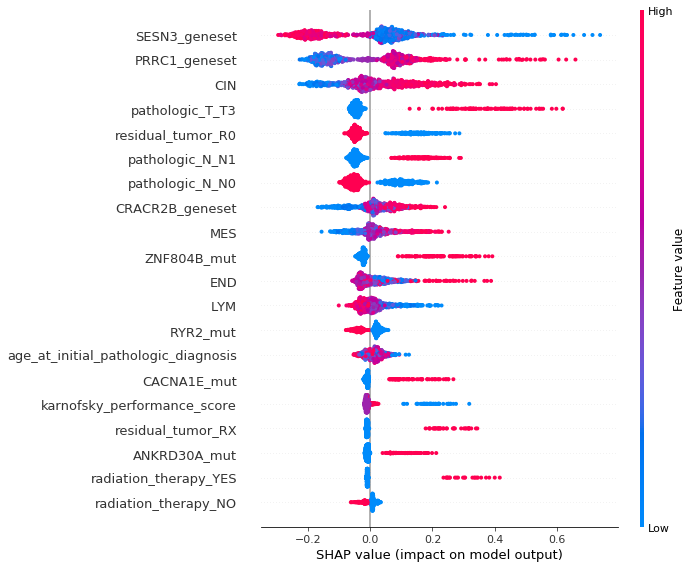

In [0]:
shap.summary_plot(shap_values, x_train_imp)

invalid value encountered in true_divide
invalid value encountered in true_divide


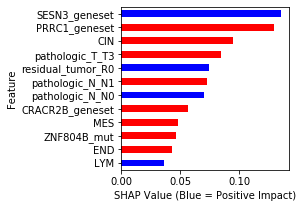

In [0]:

def ABS_SHAP(df_shap,df):
    #import matplotlib as plt
    # Make a copy of the input data
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Feature','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    # Plot it
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Feature','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Feature',right_on='Feature',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = True)[-12:]
    colorlist = k2['Sign']
    ax = k2.plot.barh(x='Feature',y='SHAP_abs',color = colorlist, figsize=(3,3),legend=False)
    ax.set_xlabel("SHAP Value (Blue = Positive Impact)")
    
ABS_SHAP(shap_values,x_train_imp) 

In [0]:
mat = pd.concat([pfs_train.copy(), x_train_imp[["SESN3_geneset"]]],
              axis=1, sort=True)

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')
print("Concordance Index = {:.4f}".format(
    1 - cph.score_))
cph.summary

Concordance Index = 0.4036


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
SESN3_geneset,-0.148002,0.86243,0.029097,-0.205031,-0.090972,0.814622,0.913043,-5.08645,3.648284e-07,21.386278


In [0]:
mat = pd.concat([pfs_train.copy(), x_train_imp[["CIN"]]],
              axis=1, sort=True)

cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')
print("Concordance Index = {:.4f}".format(
    1 - cph.score_))
cph.summary

Concordance Index = 0.4706


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
CIN,0.040801,1.041644,0.047815,-0.052915,0.134516,0.948461,1.143983,0.853303,0.393491,1.345597


To submit, you will save the data frame as a `csv` file in the `submission` Google drive folder (https://drive.google.com/open?id=1bdW_Z7K2zlUSGWl4LbGIoPSn8EjNR3pt), using your UNI as the file name.

The following is the official scoring function that check the validity of your submission and give the concordance index.

In [0]:
mat = pd.concat([pfs_train.copy(), x_train_imp[["pathologic_T_T3"]]],
              axis=1, sort=True)

cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')
print("Concordance Index = {:.4f}".format(
    1 - cph.score_))
cph.summary

Concordance Index = 0.4463


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
pathologic_T_T3,0.78423,2.190718,0.155006,0.480423,1.088036,1.616759,2.968437,5.059351,4.206868e-07,21.18075


Let's see it in action. Note you will not have access to the `pfs_test.txt` file. But you can hold out your own test set to see if it's working in your pipeline.

In [0]:
mat = pd.concat([pfs_train.copy(), x_train_imp[["PRRC1_geneset"]]],
              axis=1, sort=True)

from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')
print("Concordance Index = {:.4f}".format(
    1 - cph.score_))
cph.summary

Concordance Index = 0.4052


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
PRRC1_geneset,0.483104,1.621099,0.093646,0.299562,0.666646,1.349268,1.947695,5.158854,2.484665e-07,21.940446


In [0]:
mat = pd.concat([pfs_train.copy(), x_train_imp[["pathologic_N_N1"]]],
              axis=1, sort=True)

cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')
print("Concordance Index = {:.4f}".format(
    1 - cph.score_))
cph.summary

Concordance Index = 0.4429


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
pathologic_N_N1,0.508836,1.663354,0.126536,0.260829,0.756842,1.298006,2.131535,4.021265,0.000058,14.076417


In [0]:
mat = pd.concat([pfs_train.copy(), x_train_imp[["residual_tumor_R0"]]],
              axis=1, sort=True)

cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')
print("Concordance Index = {:.4f}".format(
    1 - cph.score_))
cph.summary

Concordance Index = 0.4426


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
residual_tumor_R0,-0.563615,0.569148,0.127566,-0.813639,-0.313591,0.443242,0.730818,-4.418237,0.00001,16.616735


In [0]:
mat = pd.concat([pfs_train.copy(), x_train_imp[["LYM"]]],
              axis=1, sort=True)

cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')
print("Concordance Index = {:.4f}".format(
    1 - cph.score_))
cph.summary

Concordance Index = 0.5152


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
LYM,0.000142,1.000142,0.04945,-0.096779,0.097063,0.907756,1.101929,0.002863,0.997716,0.003299


In [0]:
mat = pd.concat([pfs_train.copy(), x_train_imp[["END"]]],
              axis=1, sort=True)

cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')
print("Concordance Index = {:.4f}".format(
    1 - cph.score_))
cph.summary

Concordance Index = 0.4823


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
END,0.103685,1.109251,0.059664,-0.013254,0.220624,0.986833,1.246855,1.737816,0.082243,3.603959


In [0]:
mat = pd.concat([pfs_train.copy(), x_train_imp[["MES"]]],
              axis=1, sort=True)

cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')
print("Concordance Index = {:.4f}".format(
    1 - cph.score_))
cph.summary

Concordance Index = 0.4742


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
MES,0.068551,1.070956,0.04325,-0.016216,0.153319,0.983914,1.165697,1.585017,0.112963,3.146083


In [0]:
mat = pd.concat([pfs_train.copy(), x_train_imp[["CRACR2B_geneset"]]],
              axis=1, sort=True)

cph = CoxPHFitter()
cph.fit(mat, duration_col='time_to_progression_or_censor',
        event_col='progression')
print("Concordance Index = {:.4f}".format(
    1 - cph.score_))
cph.summary

Concordance Index = 0.4207


,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
CRACR2B_geneset,0.190869,1.210301,0.044018,0.104596,0.277142,1.110263,1.319354,4.336208,0.000014,16.07397


**Appendix**
PRRC1 Geneset:

PRRC1_SEC24A_SOAT1_SLC41A2_NEK6_SGPP1_CD2AP_ZNF281_IBTK_GOLM1


CRACR2B Geneset:

CRACR2B_LINC00482_QSOX1_KCNQ3_LONRF3_KRT7-AS_KIF13B_ICA1_ME3_TMEM8A_CAPN5_RPH3AL_KRT7_PLEKHA6_MISP


SESN3 Geneset:

SESN3_NTRK2_FGFR2_KRT42P_RGMA_KRT15_CYP2S1_CD9_DAPL1_OR7E28P_STAR_FMO6P_GRHL3_ST6GALNAC2_CSTA_STARD5_CERS3-AS1_PTPRZ1_NPPC_DENND2C_WNT2B_BCL11A_TRPV4_SERPINB13_MIR205HG_LINC00885_ADH7_ADAMTS17_CYB5R2_CCDC190_FOXN1_TP63_GBP6_ABCA13_C12orf54_FOXE1_NMNAT3_WNT5A_MLIP_LINC02541_BMP7_SH3BP1_GJB6_CLCA2_AADACL2_HS6ST1_IRF6_WFDC5_VWA8-AS1_FAT2_TSLP_DLX5_PTCSC2_KRT5_KRT31_NFE2L2_POLD2P1_TMEM40_SYT14_GLTP_DMRT2_KRT13_CDHR1_KCNMB2_FAM181B_LINC01752_CAPNS2_WDR72_DLX6-AS1_PRIMA1_KLHL13_IGSF11_LINC00958_PCYT1B_LINC00640_KRTAP19-1_SOX2-OT_MRAP2_DLX6_PLA2R1_WDPCP_UGT1A6_CERS3_LCE1C_NECTIN1_USH1G_EFS_SERPINB2_CLCA4_XG_ACVR1C_TCF4-AS1_FANCE_PAK5_SOX2_CACNA2D3_SERPINB11_TPRG1_C17orf99_HR_ABCC5_DYNC1I1_SDR9C7_KRT77_GSTA9P_PKP1_LINC00519_SERPINB12_SLC39A2_DSC3_MPPED1_KCNJ2-AS1_SPRR2G_DNAJC19P5_FZD6_LIMK2_EDDM13_KDM4A-AS1_KRT74_OR7E62P_LINC01206_FBXO27_GJA3_LINC01415_RAPGEFL1_CALML3_SGK1


